In [ ]:
from modelscope.pipelines import pipeline
from modelscope.utils.constant import Tasks
import torch
import os, cv2
import argparse
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['figure.figsize'] = (8, 8)
mpl.rcParams['axes.grid'] = False

import sys,os
os.environ['CUDA_VISIBLE_DEVICES']="-1"

style='watercolor'

model_id = 'damo/cv_cartoon_stable_diffusion_' + style
pipe = pipeline(Tasks.text_to_image_synthesis, model=model_id,
                    model_revision='v1.0.0', torch_dtype=torch.float16)
from diffusers.schedulers import EulerAncestralDiscreteScheduler
pipe.pipeline.scheduler = EulerAncestralDiscreteScheduler.from_config(pipe.pipeline.scheduler.config)
print('model init finished!')

In [ ]:
celeb_name = 'Taylor Swift'
prompt = 'sks style, a painting of a %s, no text'%(celeb_name)

repeat_num=4

images =  pipe({'text': prompt, 'num_images_per_prompt': repeat_num})['output_imgs']

dst_dir = './data/debug'
for i,image in enumerate(images):
    plt.figure()
    plt.imshow(image[:,:,::-1])
    dst_fn = 'ts_%s_%d.png'%(style,i)

    cv2.imwrite(os.path.join(dst_dir,dst_fn), image)



In [2]:
import cv2
import os
import numpy as np
import argparse
from source.facelib.facer import FaceAna
import source.utils as utils
from source.mtcnn_pytorch.src.align_trans import warp_and_crop_face, get_reference_facial_points
from modelscope.hub.snapshot_download import snapshot_download

from tqdm import tqdm

import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['figure.figsize'] = (8, 8)
mpl.rcParams['axes.grid'] = False

import sys,os
os.environ['CUDA_VISIBLE_DEVICES']="-1"
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
os.environ['CUDA_HOME']="/usr/local/cuda"


class FaceProcesser:
    def __init__(self, dataroot, crop_size=256, max_face=1):
        self.max_face = max_face
        self.crop_size = crop_size
        self.facer = FaceAna(dataroot)

    def filter_face(self, lm, crop_size):
        a = max(lm[:, 0])-min(lm[:, 0])
        b = max(lm[:, 1])-min(lm[:, 1])
        # print("a:%d, b:%d"%(a,b))
        if max(a, b) < int(crop_size*0.3):  # 眼间距 ？ 70
            return 0
        else:
            return 1

    def process(self, img):

        warped_face = None
        h, w, c = img.shape
        if c == 4:
            img_bgr = img[:, :, :3]
        else:
            img_bgr = img

        src_img = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
        boxes, landmarks, _ = self.facer.run(src_img)

        if boxes.shape[0] == 0:
            print('No face detected!')
            return warped_face

        # process all faces
        warped_faces = []
        i = 0

        for landmark in landmarks:
            if self.max_face and i > 0:
                continue

            if self.filter_face(landmark, self.crop_size) == 0:
                print("filtered!")
                continue

            f5p = utils.get_f5p(landmark, img_bgr)
            # face alignment
            warped_face, _ = warp_and_crop_face(
                img_bgr,
                f5p,
                ratio=0.75,
                reference_pts=get_reference_facial_points(default_square=True),
                crop_size=(self.crop_size, self.crop_size),
                return_trans_inv=True)

            warped_faces.append(warped_face)
            i = i+1

        return warped_faces


crop_size=256
max_face=1
model_dir = 'damo/cv_unet_person-image-cartoon_compound-models'
processer = FaceProcesser(
        dataroot=model_dir, crop_size=crop_size, max_face=max_face)

# warped_faces = processer.process(images[0])

src_dir ='data/debug'
src_img_ls = os.listdir(src_dir)
for image_fn in src_img_ls:
    image = cv2.imread(os.path.join(src_dir,image_fn))
    img_h, img_w, _ = image.shape
    warped_faces = processer.process(image)


    # plt.figure()
    # plt.imshow(warped_faces[:,:,::-1])





/media/112new_sde/codebase/github/DCT-Net/source/mtcnn_pytorch/src/matlab_cp2tform.py:90: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  r, _, _, _ = lstsq(X, U)


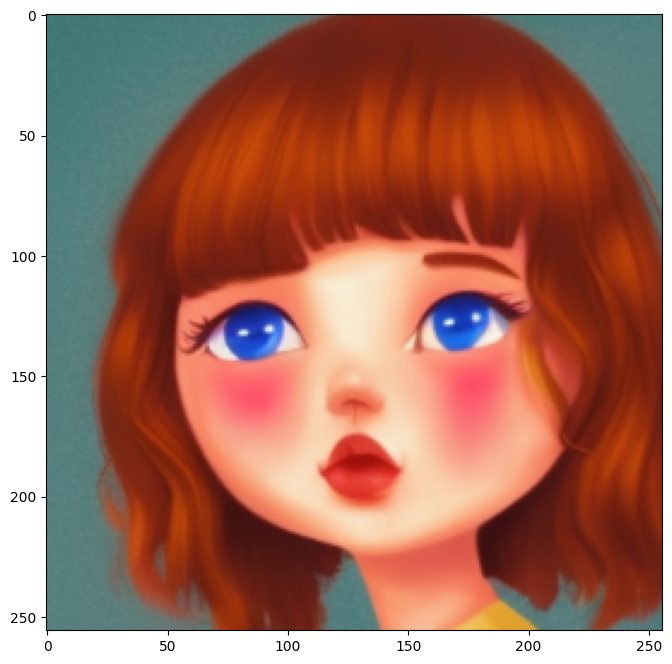

In [6]:
plt.figure()
plt.imshow(warped_faces[0][:,:,::-1])


In [ ]:
os.environ["LD_LIBRARY_PATH"]

In [ ]:
images[0]